Notebook by Zara

#### ``Data preparation``

- Resizing images to a consistent size
- Normalizing pixel values
- Splitting the dataset into training and testing sets

In [1]:
# import libraries 
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import binary_crossentropy


# Set to CPU for now
# tf.config.set_visible_devices([], 'GPU')


In [2]:
data = pd.read_csv('/Users/zaravanthoff/Desktop/MasterProject/Datasets/PublicDataset/flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt', sep='\s+',header=None)
folder_path = "/Users/zaravanthoff/Desktop/MasterProject/Datasets/PublicDataset/flickr_logos_27_dataset/flickr_logos_27_dataset_images"

In [3]:
data

,0,1,2,3,4,5,6
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93
...,...,...,...,...,...,...,...
4531,2126991906.jpg,Yahoo,6,15,6,253,54
4532,217288720.jpg,Yahoo,6,136,161,304,222
4533,2472817996.jpg,Yahoo,6,2,4,499,106
4534,2514220918.jpg,Yahoo,6,1,69,342,157


Explanation dataset:

- Column 3: x-coordinate of the top-left corner. (xmin)
- Column 4: y-coordinate of the top-left corner. (ymin)
- Column 5: x-coordinate of the bottom-right corner. (xmax)
- Column 6: y-coordinate of the bottom-right corner. (ymax)

For example, in the first row:

- Image: "144503924.jpg"
- Brand: "Adidas"
- Class label: 1
- Bounding box coordinates: (38, 12, 234, 142)

In [4]:
# Rename the columns
data.columns = ['Image', 'Class', 'Label', 'Xmin', 'Ymin', 'Xmax', 'Ymax']
data

,Image,Class,Label,Xmin,Ymin,Xmax,Ymax
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93
...,...,...,...,...,...,...,...
4531,2126991906.jpg,Yahoo,6,15,6,253,54
4532,217288720.jpg,Yahoo,6,136,161,304,222
4533,2472817996.jpg,Yahoo,6,2,4,499,106
4534,2514220918.jpg,Yahoo,6,1,69,342,157


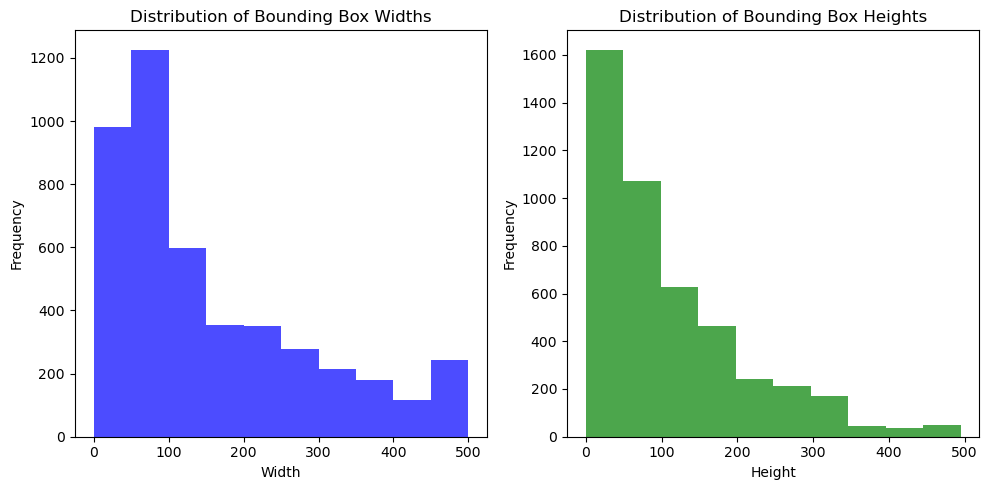

In [5]:
# # Sample dataset
# data_dict = {
#     0: ['144503924.jpg', 'Adidas', 1, 38, 12, 234, 142],
#     1: ['2451569770.jpg', 'Adidas', 1, 242, 208, 413, 331],
#     2: ['390321909.jpg', 'Adidas', 1, 13, 5, 89, 60],
#     3: ['4761260517.jpg', 'Adidas', 1, 43, 122, 358, 354],
#     4: ['4763210295.jpg', 'Adidas', 1, 83, 63, 130, 93]
# }

# # Convert the data to a DataFrame
# df = pd.DataFrame.from_dict(data_dict, orient='index', columns=['Image', 'Class', 'Label', 'Xmin', 'Ymin', 'Xmax', 'Ymax'])

# Calculate the width and height of each bounding box
data['Width'] = data['Xmax'] - data['Xmin']
data['Height'] = data['Ymax'] - data['Ymin']

# Plot histograms of bounding box width and height
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(data['Width'], bins=10, color='blue', alpha=0.7)
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.title('Distribution of Bounding Box Widths')

plt.subplot(1, 2, 2)
plt.hist(data['Height'], bins=10, color='green', alpha=0.7)
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.title('Distribution of Bounding Box Heights')

plt.tight_layout()
plt.show()

In [6]:
print(data.dtypes)

Image     object
Class     object
Label      int64
Xmin       int64
Ymin       int64
Xmax       int64
Ymax       int64
Width      int64
Height     int64
dtype: object


In [7]:
# Extract classes from the second column
classes = data['Label']

# Count the number of unique classes
num_classes = len(classes.unique())

print("Number of classes:", num_classes)

Number of classes: 6


In [ ]:
# # Provide the full path to a specific image file
# image_path = "/Users/zaravanthoff/Desktop/MasterProject/Datasets/PublicDataset/flickr_logos_27_dataset/flickr_logos_27_dataset_images/2962045.jpg"

# try:
#     # Read the image
#     image = cv2.imread(image_path)

#     if image is not None:
#         print("Image was read successfully.")
#     else:
#         print("Failed to read the image.")
# except Exception as e:
#     print(f"An error occurred while reading the image: {str(e)}")


``Resizing images to a consistent size``

In [8]:
import cv2
import os

# Define the target width and height for resizing
target_width = 416
target_height = 416

resized_images = []
labels = []

# Iterate through each row in the dataset
for index, row in data.iterrows():
    # Extract image filename from the dataset
    image_filename = row[0]  # Accessing by integer index 0
    
    # Construct the full path to the image
    image_path = os.path.join(folder_path, image_filename)
    
    try:
        # Read the image using OpenCV
        image = cv2.imread(image_path)
        
        # Check if the image was read successfully
        if image is None:
            raise FileNotFoundError(f"Unable to read image at path: {image_path}")
        
        # Resize the image to the target size
        resized_image = cv2.resize(image, (target_width, target_height))
        
        # Append resized image to the list
        resized_images.append(resized_image)
        
        # Append label to the list (assuming label is in the second column of the dataframe)
        label = row[2]
        labels.append(label)
        
        print(f"Image processed successfully: {image_filename}")
    except Exception as e:
        print(f"Error processing image at path {image_path}: {str(e)}")

/var/folders/bs/xnv9qfhn03xdhr_rlq0jjbq40000gn/T/ipykernel_23557/2537228588.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_filename = row[0]  # Accessing by integer index 0
/var/folders/bs/xnv9qfhn03xdhr_rlq0jjbq40000gn/T/ipykernel_23557/2537228588.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[2]


Image processed successfully: 144503924.jpg
Image processed successfully: 2451569770.jpg
Image processed successfully: 390321909.jpg
Image processed successfully: 4761260517.jpg
Image processed successfully: 4763210295.jpg
Image processed successfully: 4763210295.jpg
Image processed successfully: 4763210295.jpg
Image processed successfully: 4763210295.jpg
Image processed successfully: 4763210295.jpg
Image processed successfully: 4763210295.jpg
Image processed successfully: 4763210295.jpg
Image processed successfully: 4763210295.jpg
Image processed successfully: 1230939811.jpg
Image processed successfully: 1230939811.jpg
Image processed successfully: 2550056374.jpg
Image processed successfully: 3294282629.jpg
Image processed successfully: 3294282629.jpg
Image processed successfully: 3294282629.jpg
Image processed successfully: 3294282629.jpg
Image processed successfully: 3294282629.jpg
Image processed successfully: 3294282629.jpg
Image processed successfully: 3294282629.jpg
Image proces

In [9]:
# Convert lists to numpy arrays
resized_images = np.array(resized_images)
labels = np.array(labels)

In [10]:
# Check the shape of resized images and labels
print("Resized Images Shape:", resized_images.shape)
print("Labels Shape:", labels.shape)

Resized Images Shape: (4536, 416, 416, 3)
Labels Shape: (4536,)


``Normalizization of pixel values``

Scaling the pixel values to be within a certain range, such as [0. 1]. This can help the neural network converge faster during training. Dividing by 255.0 normalizes the pixel values to be within the range [0, 1]. 
- Grayscale images: For grayscale images, each pixel value represents the intensity of that pixel, and it typically ranges from 0 (black) and 255 (white). Dividing by 255 scales these values to the range [0, 1], where 0 represents black and 1 represents white.
- Color images: For color images, each pixel has three channels (red, green, and blue). Each channel has pixel values ranging from 0 to 255. By dividing by 255, we normalize each channel independelty, ensuring that each channel's values fall within the [0, 1] range. 


In [11]:
# Normalize pixel values
resized_images = resized_images.astype('float32') / 255.0

# Check the range of pixel values after normalization
print("Minimum Pixel Value After Normalization:", np.min(resized_images))
print("Maximum Pixel Value After Normalization:", np.max(resized_images))

KeyboardInterrupt: 

``Augmentation (optional)``

Augmentation refers to the technqiue of artificially increasing the size of a dataset by applying various transformations to the existing data samples. These transformations introduce variations in the data while preserving its original meaning, thereby making the model more robust and improving its generalization ability. These operations (roation, flipping, scaling, shifting, zooming, changing brightness/contrast) mimic real-world variations that can occur in the data and help the model learn to generalize better to unseen examples.

``Generate anchor boxes``

Generate anchor boxes based on the distribution of object sizes in the training dataset. Anchor boxes are used by YOLO for predicting bounding boxes and help improve detection accuracy.

**1) Compute Box Sizes**

Calculate the width and height of each ground truth bounding box. You can do this by subtracting the x-coordinates of the top-left and bottom-right corners for width, and the y-coordinates for height.

In [ ]:
# Initialize a list to store the computed box sizes
box_sizes = []

# Iterate through each row in the dataset
for index, row in data.iterrows():
    # Extract the bounding box coordinates
    x1, y1, x2, y2 = row[3], row[4], row[5], row[6]  # Assuming the bounding box coordinates are in columns 3 to 6
    
    # Compute the width and height of the bounding box
    width = x2 - x1
    height = y2 - y1
    
    # Append the computed box size to the list
    box_sizes.append((width, height))

# Print the first few computed box sizes
print("Computed Box Sizes:")
print(box_sizes[:5])

**2) Cluster box sizes**

Use clustering algorithms such as k-means clustering to group the box sizes into clusters based on their width and height. This will help identify common sizes and aspect ratios of objects in the dataset.

In [ ]:
# Convert the box sizes list to a numpy array
box_sizes_array = np.array(box_sizes)

# Define the number of clusters (you can adjust this based on your dataset)
num_clusters = 5

# Initialize the KMeans clustering model
kmeans = KMeans(n_clusters=num_clusters)

# Fit the model to the box sizes data
kmeans.fit(box_sizes_array)

# Get the centroids of the clusters
centroids = kmeans.cluster_centers_

# Print the centroids of the clusters
print("Cluster Centroids:")
print(centroids)


The KMeans clustering algorithm has computed the centroids of the clusters. Each centroid represents a group of box sizes with similar dimensions. The centroids are displayed as pairs of width and height values.

Here are the centroids (representative box sizes) for each cluster:

- Cluster 1: Width = 147.50, Height = 100.05
- Cluster 2: Width = 258.43, Height = 196.78
- Cluster 3: Width = 54.28, Height = 41.55
- Cluster 4: Width = 394.92, Height = 350.45
- Cluster 5: Width = 437.14, Height = 160.91

These centroids can serve as anchor box dimensions for YOLO object detection

**Encode the bounding boxes**

- Convert the bounding box coordinates (x_min, y_min, x_max, y_max) into the format expected by YOLO, which is (x_center, y_center, width, height). This is often referred to as "box normalization."
- Normalize the box coordinates to be in the range [0, 1], where (0, 0) represents the top-left corner of the image, and (1, 1) represents the bottom-right corner.
- Concatenate the normalized box coordinates with the class label for each bounding box.
- Ensure that the labels are in the same format for each image and match the output format expected by the YOLO model.

In [ ]:
def convert_to_yolo_format(x_min, y_min, x_max, y_max, image_width, image_height):
    # Calculate center coordinates
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    
    # Normalize coordinates to range [0, 1]
    x_center /= image_width
    y_center /= image_height
    
    # Calculate width and height
    width = (x_max - x_min) / image_width
    height = (y_max - y_min) / image_height
    
    return x_center, y_center, width, height

# Example usage:
x_min = 100
y_min = 50
x_max = 200
y_max = 150
image_width = 416  # Example image width
image_height = 416  # Example image height

x_center, y_center, width, height = convert_to_yolo_format(x_min, y_min, x_max, y_max, image_width, image_height)
print("Bounding Box in YOLO Format:")
print("x_center:", x_center)
print("y_center:", y_center)
print("Width:", width)
print("Height:", height)

In [ ]:
def normalize_coordinates(x_min, y_min, x_max, y_max, image_width, image_height):
    # Normalize coordinates to range [0, 1]
    x_min /= image_width
    y_min /= image_height
    x_max /= image_width
    y_max /= image_height
    
    return x_min, y_min, x_max, y_max

# Example usage:
x_min = 100
y_min = 50
x_max = 200
y_max = 150
image_width = 416  # Example image width
image_height = 416  # Example image height

x_min_norm, y_min_norm, x_max_norm, y_max_norm = normalize_coordinates(x_min, y_min, x_max, y_max, image_width, image_height)
print("Normalized Box Coordinates:")
print("x_min_norm:", x_min_norm)
print("y_min_norm:", y_min_norm)
print("x_max_norm:", x_max_norm)
print("y_max_norm:", y_max_norm)

In [ ]:
def concatenate_coordinates_with_label(x_min_norm, y_min_norm, x_max_norm, y_max_norm, class_label):
    # Concatenate normalized coordinates with the class label
    concatenated_data = [x_min_norm, y_min_norm, x_max_norm, y_max_norm, class_label]
    
    return concatenated_data

# Example usage:
x_min_norm = 0.24
y_min_norm = 0.18
x_max_norm = 0.65
y_max_norm = 0.42
class_label = 3  # Example class label

concatenated_data = concatenate_coordinates_with_label(x_min_norm, y_min_norm, x_max_norm, y_max_norm, class_label)
print("Concatenated Data (Normalized Box Coordinates + Class Label):", concatenated_data)


Show bounding boxes

In [2]:
# Load the image
image_path = "/Users/zaravanthoff/Desktop/MasterProject/Datasets/PublicDataset/flickr_logos_27_dataset/flickr_logos_27_dataset_images/40394187.jpg"
image = cv2.imread(image_path)

# Define anchor box centroids (example centroids)
centroids = np.array([[147.5, 100.0],
                       [258.4, 196.8],
                       [54.3, 41.6],
                       [394.9, 350.4],
                       [437.1, 160.9]])

# Define anchor box sizes (example sizes)
box_sizes = np.array([[50, 50],
                      [100, 100],
                      [150, 50],
                      [50, 150],
                      [100, 200]])

# Draw anchor boxes on the image
for centroid, size in zip(centroids, box_sizes):
    x1 = int(centroid[0] - size[0] / 2)
    y1 = int(centroid[1] - size[1] / 2)
    x2 = int(centroid[0] + size[0] / 2)
    y2 = int(centroid[1] + size[1] / 2)
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the image with anchor boxes
cv2.imshow("Image with Anchor Boxes", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

``Split data into train, test, validation``

In YOLO, the labels typically consist of bounding boxes along with class labels. Each bounding box is represented by its coordinates (x, y) of the center, width, and height, along with the class label. This information is crucial for training the YOLO model to detect objects accurately.

In [3]:
# Define your features (resized images) and labels
X = resized_images
y = labels

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Check the shapes of the split datasets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


NameError: name 'resized_images' is not defined

In [ ]:
# # Concatenate resized images and labels
# concatenated_data = list(zip(resized_images, labels))

# # Split the concatenated data into train, validation, and test sets
# train_data, test_val_data = train_test_split(concatenated_data, test_size=0.2, random_state=42)
# val_data, test_data = train_test_split(test_val_data, test_size=0.5, random_state=42)

# # Unzip the train, validation, and test sets
# X_train, y_train = zip(*train_data)
# X_val, y_val = zip(*val_data)
# X_test, y_test = zip(*test_data)

# # Convert to numpy arrays
# X_train = np.array(X_train)
# y_train = np.array(y_train)
# X_val = np.array(X_val)
# y_val = np.array(y_val)
# X_test = np.array(X_test)
# y_test = np.array(y_test)

# # Print the shapes of the split datasets
# print("Train data shape:", X_train.shape, y_train.shape)
# print("Validation data shape:", X_val.shape, y_val.shape)
# print("Test data shape:", X_test.shape, y_test.shape)


Training set shape: (2902, 416, 416, 3)

- The training set contains 2902 samples.
- Each sample is an image with dimensions 416x416 pixels.
- The images are in color, represented by 3 channels (RGB).

In [ ]:
print("Data type of X (features):", X_train.dtype)
print("Data type of y (labels):", y_train.dtype)

In [ ]:
y_train

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# from keras.utils import to_categorical

# # Encode categorical labels to integers
# label_encoder = LabelEncoder()
# y_train = label_encoder.fit_transform(y_train)
# y_val = label_encoder.transform(y_val)
# y_test = label_encoder.transform(y_test)

# # Convert integer labels to one-hot encoding
# num_classes = len(label_encoder.classes_)
# y_train = to_categorical(y_train, num_classes=num_classes)
# y_val = to_categorical(y_val, num_classes=num_classes)
# y_test = to_categorical(y_test, num_classes=num_classes)


In [ ]:
y_train

In [ ]:
print("Data type of X (features):", X_train.dtype)
print("Data type of y (labels):", y_train.dtype)

One-hot encoded training labels shape: (2902, 27)

- The training set contains 2902 samples.
- Each sample is associated with one of 27 classes.
- The labels are encoded using one-hot encoding, where each class is represented by a binary vector of length 27 (the number of classes). Only one element in each vector is 1 (indicating the presence of that class), and the rest are 0s.

In [ ]:
y_train

In [ ]:
X_train

In [ ]:
y_train # training labels

-------------------------

## **YOLO**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def build_yolo_model(input_shape, num_classes, num_anchors):
    # Input layer
    inputs = layers.Input(shape=input_shape)
    
    # Backbone (e.g., Darknet-53)
    backbone = build_backbone(inputs)
    
    # Head (e.g., YOLO head)
    output_layers = build_yolo_head(backbone, num_classes, num_anchors)
    
    # Define the model
    model = tf.keras.Model(inputs, output_layers)
    
    return model

def build_backbone(inputs):
    # Example backbone architecture (e.g., Darknet-53)
    # Replace this with your desired backbone architecture
    # Example: 
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    # Add more layers as needed...
    return x

def build_yolo_head(backbone, num_classes, num_anchors):
    # Example YOLO head architecture
    # Replace this with your desired YOLO head architecture
    # Example:
    x = layers.Conv2D(512, (3,3), padding='same', activation='relu')(backbone)
    x = layers.Conv2D(num_anchors * (4 + 1 + num_classes), (1, 1), padding='valid')(x)
    
    # Calculate the spatial dimensions of the feature map
    grid_height, grid_width = backbone.shape[1:3]  # Assuming shape is (batch_size, height, width, channels)
    
    # Reshape the output tensor
    x = layers.Reshape((grid_height, grid_width, num_anchors, 4 + 1 + num_classes))(x)
    
    # Add more layers as needed...
    return x


In [ ]:
# Define input shape, number of classes, and number of anchors
input_shape = (416, 416, 3)  # Example input shape
num_classes = 6  # Example number of classes
num_anchors = 5  # Example number of anchors

# Build the YOLO model
yolo_model = build_yolo_model(input_shape, num_classes, num_anchors)

# Compile the model
yolo_model.compile(optimizer='adam')

# Print model summary
yolo_model.summary()

In [ ]:
# Train the model
history = yolo_model.fit(
    x=X_train,        # Training features
    y=y_train,        # Training labels
    epochs=10,        # Number of epochs
    batch_size=32,    # Batch size
    validation_data=(X_val, y_val)  # Validation dataset
)

In [ ]:
# # Evaluate the model
# loss, accuracy = yolo_model.evaluate(x=test_dataset)  # Test dataset

# print("Test Loss:", loss)
# print("Test Accuracy:", accuracy)

-----